# Supply Chain Optimization for a Logistics Company

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from datetime import datetime, timedelta
import random

In [3]:
# set options to be maximum rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# hide all warnings runtime
import warnings
warnings.filterwarnings('ignore')

# 1. Generating Synthetic Supply Chain Data

## ✅ Dataset 1: Delivery Records (delivery_records.csv)

In [4]:
fake = Faker()
np.random.seed(42)  # For reproducibility
random.seed(42)
num_rows = 40000

# Generate unique IDs
delivery_ids = [f"D{str(i).zfill(6)}" for i in range(1, num_rows + 1)]
route_ids = [random.randint(1, 500) for _ in range(num_rows)]

# Generate dates
dates = [fake.date_between(start_date='-6M', end_date='today').strftime("%d-%m-%Y") for _ in range(num_rows)]

# Generate Origins and Destinations (city names)
origins = [fake.city() for _ in range(num_rows)]
destinations = [fake.city() for _ in range(num_rows)]

# DeliveryTime in hours: Normal range is 2-10 hours, add 8% missing
delivery_time = np.random.normal(loc=6, scale=2, size=num_rows).round(2)
missing_indices = random.sample(range(num_rows), int(0.08 * num_rows))
for idx in missing_indices:
    delivery_time[idx] = np.nan

# Cost: Normal cost with some high outliers
cost = np.random.normal(loc=100, scale=25, size=num_rows).round(2)
outlier_indices = random.sample(range(num_rows), int(0.02 * num_rows))
for idx in outlier_indices:
    cost[idx] *= 3  # inflate outliers

# Combine
dlv_records = pd.DataFrame({
    'DeliveryID': delivery_ids,
    'RouteID': route_ids,
    'Date': dates,
    'Origin': origins,
    'Destination': destinations,
    'DeliveryTime': delivery_time,
    'Cost': cost
})

dlv_records.to_csv('delivery_records.csv', index=False)

## ✅ Dataset 2: Route Information (routes_info.csv)

In [5]:
np.random.seed(42)  # For reproducibility
random.seed(42)
num_routes = 500

route_ids = list(range(1, num_routes + 1))
distances = np.random.normal(loc=120, scale=40, size=num_routes).round(2)
# Some routes are shorter or longer
traffic_indices = np.random.randint(1, 11, size=num_routes).astype(float)

# Add 5% missing traffic index
missing_traffic_idx = random.sample(range(num_routes), int(0.05 * num_routes))
for idx in missing_traffic_idx:
    traffic_indices[idx] = np.nan

warehouse_ids = [random.randint(1, 50) for _ in range(num_routes)]

routes_info = pd.DataFrame({
    'RouteID': route_ids,
    'Distance': distances,
    'TrafficIndex': traffic_indices,
    'WarehouseID': warehouse_ids
})

routes_info.to_csv('routes_info.csv', index=False)

## ✅ Dataset 3: Warehouse Data (warehouse_data.csv)

In [6]:
np.random.seed(42)  # For reproducibility
random.seed(42)
num_warehouses = 50

warehouse_ids = list(range(1, num_warehouses + 1))
locations = [fake.city() for _ in range(num_warehouses)]
capacities = np.random.randint(500, 10000, size=num_warehouses)
staff_counts = np.random.randint(5, 100, size=num_warehouses)

warehouse_data = pd.DataFrame({
    'WarehouseID': warehouse_ids,
    'Location': locations,
    'Capacity': capacities,
    'StaffCount': staff_counts
})

warehouse_data.to_csv('warehouse_data.csv', index=False)

### ***Joining All Datasets***

In [7]:
dlv_records = pd.read_csv("delivery_records.csv")
routes_info = pd.read_csv("routes_info.csv")
warehouse_data = pd.read_csv("warehouse_data.csv")

# Merge on RouteID (many-to-one join

df = pd.merge(dlv_records, routes_info, on="RouteID", how="left")
df = pd.merge(df, warehouse_data, on="WarehouseID", how="left")

# 🔍 Step 2: Data Preprocessing & Feature Engineering

In [8]:
df.sample(5)

,DeliveryID,RouteID,Date,Origin,Destination,DeliveryTime,Cost,Distance,TrafficIndex,WarehouseID,Location,Capacity,StaffCount
33834,D033835,286,09-05-2025,Port Pamelafort,North Emmastad,3.93,133.62,41.92,7.0,12,Port Justin,1269,67
31906,D031907,26,31-05-2025,South Ryanstad,East Steven,NaN,125.64,124.44,2.0,23,North Lisa,9774,76
16637,D016638,83,05-03-2025,North Karla,East Jasminechester,4.40,66.09,179.12,2.0,44,South Jenny,3112,92
29875,D029876,452,24-04-2025,South Jennifer,Lake Brianborough,6.74,79.12,158.21,1.0,45,Lake Drewland,7541,5
28568,D028569,345,12-01-2025,Jacobtown,Smithmouth,7.23,65.90,101.16,10.0,39,Grahambury,9338,49


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DeliveryID    40000 non-null  object 
 1   RouteID       40000 non-null  int64  
 2   Date          40000 non-null  object 
 3   Origin        40000 non-null  object 
 4   Destination   40000 non-null  object 
 5   DeliveryTime  36800 non-null  float64
 6   Cost          40000 non-null  float64
 7   Distance      40000 non-null  float64
 8   TrafficIndex  37968 non-null  float64
 9   WarehouseID   40000 non-null  int64  
 10  Location      40000 non-null  object 
 11  Capacity      40000 non-null  int64  
 12  StaffCount    40000 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 4.0+ MB


### Changing Data Types

In [10]:
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")

In [11]:
df['Date'].dtype

dtype('<M8[ns]')

## Handling Negative Values in Data

In [12]:
df.describe()

,RouteID,Date,DeliveryTime,Cost,Distance,TrafficIndex,WarehouseID,Capacity,StaffCount
count,40000.000000,40000,36800.000000,40000.000000,40000.000000,37968.000000,40000.000000,40000.000000,40000.000000
mean,250.276750,2025-03-24 05:58:22.800000,5.997937,104.054071,120.490467,5.469211,25.002975,5356.360900,54.069100
min,1.000000,2024-12-23 00:00:00,-2.930000,-11.570000,-9.650000,1.000000,1.000000,689.000000,5.000000
25%,125.000000,2025-02-07 00:00:00,4.640000,83.680000,92.010000,3.000000,12.000000,2933.000000,22.000000
50%,250.000000,2025-03-24 00:00:00,6.000000,100.890000,120.520000,6.000000,25.000000,5811.000000,57.000000
75%,376.000000,2025-05-09 00:00:00,7.350000,118.322500,145.820000,8.000000,38.000000,7599.000000,82.000000
max,500.000000,2025-06-23 00:00:00,14.960000,553.560000,274.110000,10.000000,50.000000,9774.000000,99.000000
std,144.469584,NaN,2.001703,38.546832,39.011869,2.858384,14.530970,2665.702009,30.501935


In [13]:
cols = ['Cost', 'DeliveryTime', 'Distance']

for col in cols:
    count = (df[col] < 0).sum()
    print(f"Negative values in '{col}':{count}")

Negative values in 'Cost':3
Negative values in 'DeliveryTime':52
Negative values in 'Distance':72


In [14]:
cols = ['Cost', 'DeliveryTime', 'Distance']

for col in cols:
    mean_val = df[df[col] >= 0][col].mean() # mean excluding negatives
    df[col] = df[col].apply(lambda x:mean_val if x < 0 else x)

In [15]:
cols = ['Cost', 'DeliveryTime', 'Distance']

for col in cols:
    count = (df[col] < 0).sum()
    print(f"Negative values in '{col}':{count}")

Negative values in 'Cost':0
Negative values in 'DeliveryTime':0
Negative values in 'Distance':0


## Handling Missing Values

In [16]:
df.isnull().sum() / len(df) * 100

DeliveryID      0.00
RouteID         0.00
Date            0.00
Origin          0.00
Destination     0.00
DeliveryTime    8.00
Cost            0.00
Distance        0.00
TrafficIndex    5.08
WarehouseID     0.00
Location        0.00
Capacity        0.00
StaffCount      0.00
dtype: float64

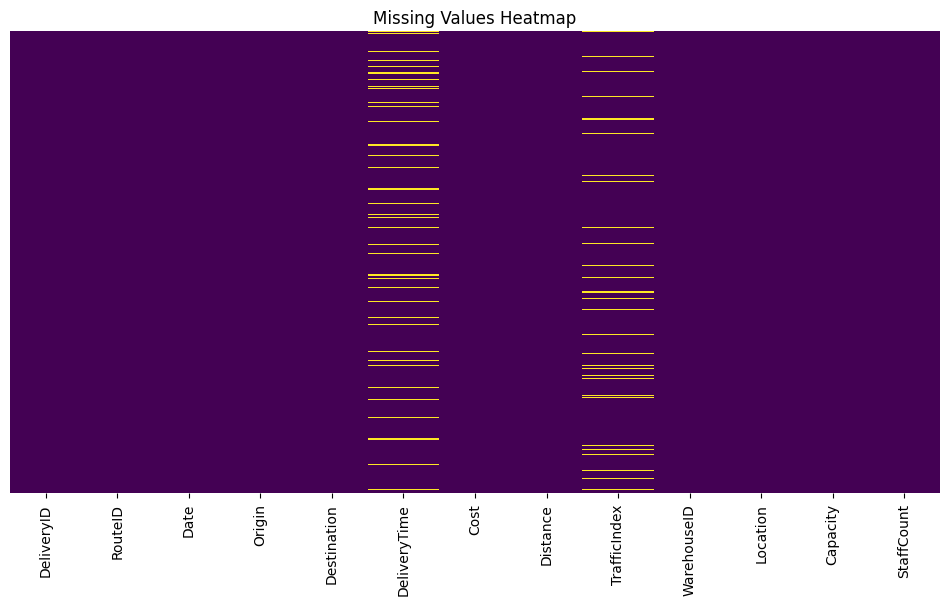

In [17]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [18]:
#1
df['DeliveryTime'].describe()

count    36800.000000
mean         6.007300
std          1.986053
min          0.010000
25%          4.650000
50%          6.007300
75%          7.350000
max         14.960000
Name: DeliveryTime, dtype: float64

In [19]:
df['DeliveryTime'].skew()

np.float64(0.036648479907176096)

<Axes: xlabel='DeliveryTime', ylabel='Count'>

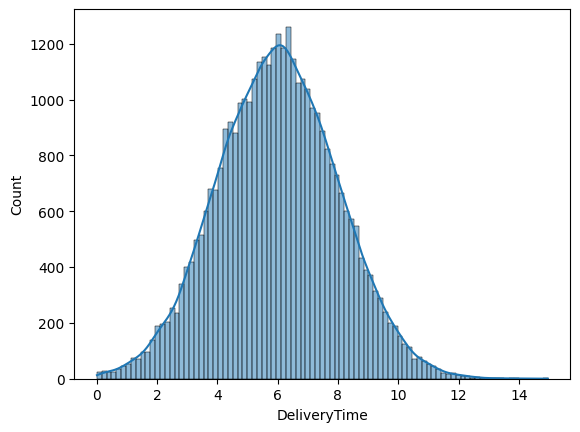

In [20]:
# To check Data Distribution
sns.histplot(df['DeliveryTime'], kde=True)

In [21]:
num_missing = df['DeliveryTime'].isna().sum()

df.loc[df['DeliveryTime'].isna(), 'DeliveryTime'] = df['DeliveryTime'].dropna().sample(n=num_missing, replace=True).values

<Axes: xlabel='DeliveryTime', ylabel='Count'>

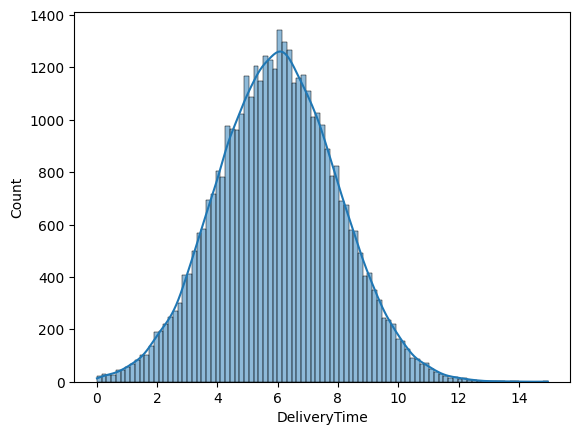

In [22]:
# After Filling Values
sns.histplot(df['DeliveryTime'], kde=True)

In [23]:
df['DeliveryTime'].isna().sum()

np.int64(0)

In [24]:
#2
df['TrafficIndex'].skew()

np.float64(-0.036516077645668124)

<Axes: xlabel='TrafficIndex', ylabel='Count'>

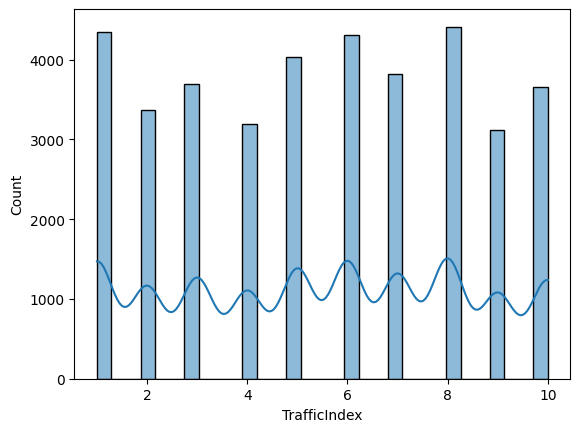

In [25]:
sns.histplot(df['TrafficIndex'], kde=True)

In [26]:
df['TrafficIndex'].mean()

np.float64(5.469210914454277)

In [27]:
df['TrafficIndex'].median()

np.float64(6.0)

In [28]:
# As data is systematic, so using mean to fill null values
df['TrafficIndex'] = df['TrafficIndex'].fillna(df['TrafficIndex'].mean())

<Axes: xlabel='TrafficIndex', ylabel='Count'>

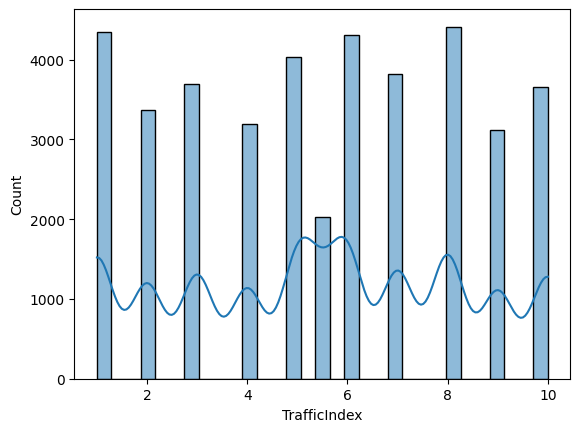

In [29]:
sns.histplot(df['TrafficIndex'], kde=True)

In [30]:
df.isnull().sum()

DeliveryID      0
RouteID         0
Date            0
Origin          0
Destination     0
DeliveryTime    0
Cost            0
Distance        0
TrafficIndex    0
WarehouseID     0
Location        0
Capacity        0
StaffCount      0
dtype: int64

## Handling Outliers

In [31]:
def check_outliers(df):
    outlier_summary = {}

    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)][col]
        outlier_summary[col] = {
            "count": len(outliers),
            "percent": round(100 * len(outliers) / len(df), 2)
        }

    return pd.DataFrame(outlier_summary).T.sort_values(by="percent", ascending=False)

In [32]:
outlier_report = check_outliers(df)
print(outlier_report)

              count  percent
Cost          963.0     2.41
DeliveryTime  235.0     0.59
Distance      230.0     0.57
RouteID         0.0     0.00
TrafficIndex    0.0     0.00
WarehouseID     0.0     0.00
Capacity        0.0     0.00
StaffCount      0.0     0.00


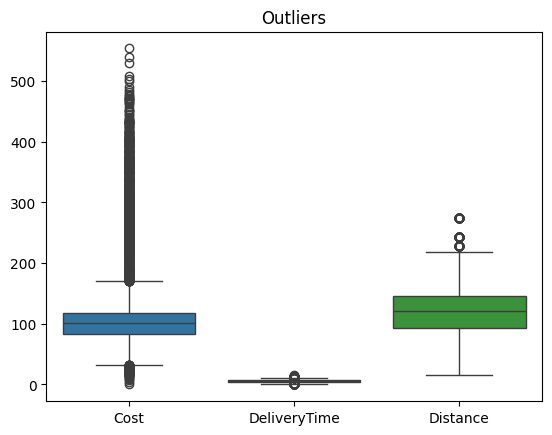

In [33]:
sns.boxplot(data=df[['Cost', 'DeliveryTime', 'Distance']])
plt.title('Outliers')
plt.show()

In [34]:
cols = ['Cost', 'DeliveryTime', 'Distance']

for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df[col] = df[col].clip(lower=lower, upper=upper)

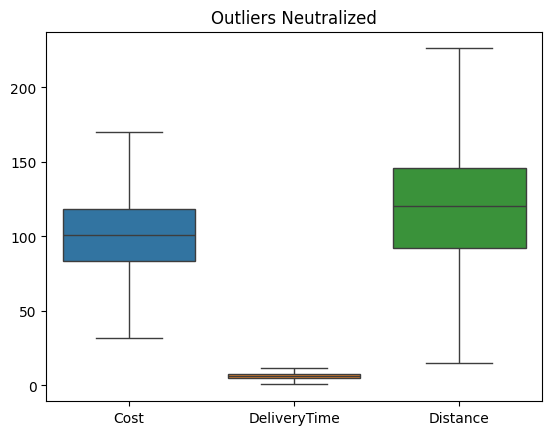

In [35]:
sns.boxplot(data=df[['Cost', 'DeliveryTime', 'Distance']])
plt.title('Outliers Neutralized')
plt.show()

In [36]:
outlier_report = check_outliers(df)
print(outlier_report)

              count  percent
RouteID         0.0      0.0
DeliveryTime    0.0      0.0
Cost            0.0      0.0
Distance        0.0      0.0
TrafficIndex    0.0      0.0
WarehouseID     0.0      0.0
Capacity        0.0      0.0
StaffCount      0.0      0.0


## Feature Engineering

In [37]:
#1 Cost per Mile (Efficieny Check)
df['Cost_per_Mile'] = df['Cost'] / df['Distance']

In [38]:
#2 Categories 
df['DistanceGroup'] = pd.cut(df['Distance'], bins=[0, 50, 150, 250], labels=['Short', 'Medium', 'Long'])

In [39]:
#3 Delivery Month Feature
df['Month'] = df['Date'].dt.strftime('%B%y')

## EDA

In [40]:
df.head()

,DeliveryID,RouteID,Date,Origin,Destination,DeliveryTime,Cost,Distance,TrafficIndex,WarehouseID,Location,Capacity,StaffCount,Cost_per_Mile,DistanceGroup,Month
0,D000001,328,2025-06-15,Smithview,Wilsonview,6.99,88.20,151.67,5.469211,48,Ashleyland,7599,67,0.581526,Long,June25
1,D000002,58,2025-05-14,Thompsonborough,Jonathonshire,5.72,125.32,107.63,5.469211,24,New William,3058,82,1.164359,Medium,May25
2,D000003,13,2025-01-08,Elizabethview,Pattersontown,7.30,95.05,129.68,5.469211,11,New Lisamouth,2185,97,0.732958,Medium,January25
3,D000004,380,2025-02-09,Lewisside,North Raymond,9.05,102.26,87.67,5.469211,1,Port Jamesberg,7770,82,1.166420,Medium,February25
4,D000005,141,2025-05-10,Danielleshire,Colleentown,5.53,117.93,129.10,5.469211,44,South Jenny,3112,92,0.913478,Medium,May25


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DeliveryID     40000 non-null  object        
 1   RouteID        40000 non-null  int64         
 2   Date           40000 non-null  datetime64[ns]
 3   Origin         40000 non-null  object        
 4   Destination    40000 non-null  object        
 5   DeliveryTime   40000 non-null  float64       
 6   Cost           40000 non-null  float64       
 7   Distance       40000 non-null  float64       
 8   TrafficIndex   40000 non-null  float64       
 9   WarehouseID    40000 non-null  int64         
 10  Location       40000 non-null  object        
 11  Capacity       40000 non-null  int64         
 12  StaffCount     40000 non-null  int64         
 13  Cost_per_Mile  40000 non-null  float64       
 14  DistanceGroup  40000 non-null  category      
 15  Month          4000

In [42]:
df.corr(numeric_only=True)

,RouteID,DeliveryTime,Cost,Distance,TrafficIndex,WarehouseID,Capacity,StaffCount,Cost_per_Mile
RouteID,1.000000,0.004298,-0.002523,0.020429,0.024071,-0.066520,-0.013117,-0.038722,-0.012980
DeliveryTime,0.004298,1.000000,0.000818,0.002424,0.003515,0.005604,-0.006856,-0.002226,-0.002014
Cost,-0.002523,0.000818,1.000000,0.005000,0.001385,0.001385,-0.003215,0.013576,0.456711
Distance,0.020429,0.002424,0.005000,1.000000,0.001617,0.070245,-0.052983,0.013162,-0.683693
TrafficIndex,0.024071,0.003515,0.001385,0.001617,1.000000,-0.055090,-0.074189,0.004738,-0.002245
WarehouseID,-0.066520,0.005604,0.001385,0.070245,-0.055090,1.000000,0.115581,0.090841,-0.036300
Capacity,-0.013117,-0.006856,-0.003215,-0.052983,-0.074189,0.115581,1.000000,-0.002386,0.035937
StaffCount,-0.038722,-0.002226,0.013576,0.013162,0.004738,0.090841,-0.002386,1.000000,0.026090
Cost_per_Mile,-0.012980,-0.002014,0.456711,-0.683693,-0.002245,-0.036300,0.035937,0.026090,1.000000


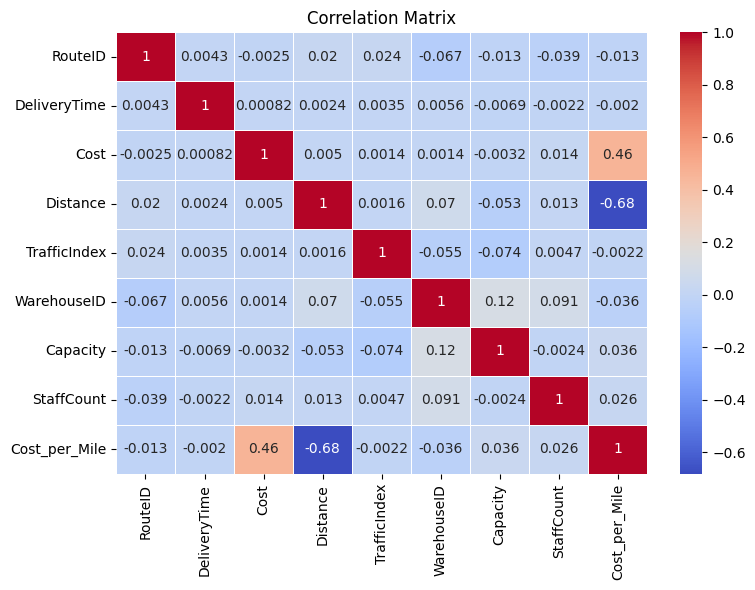

In [43]:
# Heatmap for Better Visual Understanding

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Bottleneck 1 

### Cost per Mile (Route Efficiency Check)

In [44]:
df['Cost_per_Mile'].mean()

np.float64(0.9599273309075468)

In [45]:
# Most Inefficient Routes
cost_per_mile = df.groupby('RouteID')['Cost_per_Mile'].mean().sort_values(ascending=False)
cost_per_mile.head(25) 

RouteID
75     6.730819
472    3.669760
443    2.872194
383    2.835680
432    2.700281
237    2.599318
80     2.550309
286    2.383693
38     2.378766
111    2.369640
14     2.269729
222    2.236638
430    2.158151
15     2.008394
50     1.991447
397    1.985782
439    1.895946
483    1.826046
131    1.803934
224    1.768862
143    1.730107
413    1.724433
401    1.724337
255    1.723786
96     1.712810
Name: Cost_per_Mile, dtype: float64

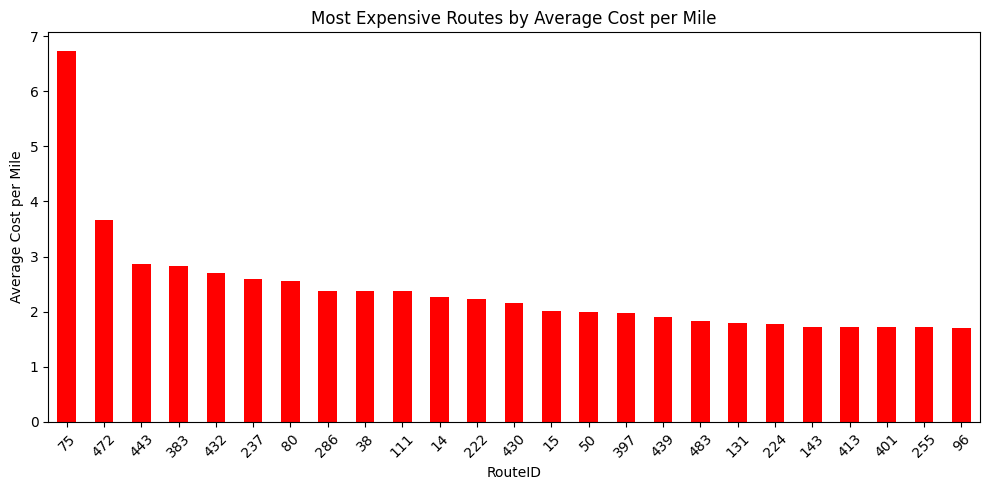

In [46]:
cost_per_mile.head(25).plot(kind='bar',color = 'red', figsize=(10, 5))
plt.title('Most Expensive Routes by Average Cost per Mile')
plt.ylabel('Average Cost per Mile')
plt.xlabel('RouteID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
def analyze_routes(df):

    routes_summary = df.groupby(['RouteID']).agg(
        TotalDeliveries = ('RouteID', 'count'),
        TotalCost =('Cost', 'sum'),
        TotalDistance =('Distance', 'sum'),
        AvgCostperMile = ('Cost_per_Mile', 'mean'),
        AvgDeliveryTime = ('DeliveryTime', 'mean')  
    ).reset_index()

   # warehouse_summary['Cost_per_Mile'] = warehouse_summary['Cost'] / warehouse_summary['Distance']
    routes_summary = routes_summary.sort_values(by='AvgCostperMile', ascending=False)
    return routes_summary

In [48]:
routes_summary = analyze_routes(df)
routes_summary.head(10)

,RouteID,TotalDeliveries,TotalCost,TotalDistance,AvgCostperMile,AvgDeliveryTime
74,75,78,7985.30875,1186.38,6.730819,5.890769
471,472,76,7786.93625,2121.92,3.669760,5.977368
442,443,74,7927.83125,2760.20,2.872194,6.163378
382,383,76,7551.52875,2663.04,2.835680,6.336711
431,432,66,6848.93750,2536.38,2.700281,6.042576
236,237,88,8918.57250,3431.12,2.599318,5.740795
79,80,74,7643.27625,2997.00,2.550309,6.129595
285,286,81,8093.87625,3395.52,2.383693,6.120741
37,38,80,7918.43625,3328.80,2.378766,6.018750
110,111,72,7379.06000,3114.00,2.369640,6.048611


## Bottleneck 2

### Distance Group

In [49]:
df.groupby('DistanceGroup')['Cost_per_Mile'].mean()

DistanceGroup
Short     2.846441
Medium    1.000020
Long      0.594515
Name: Cost_per_Mile, dtype: float64

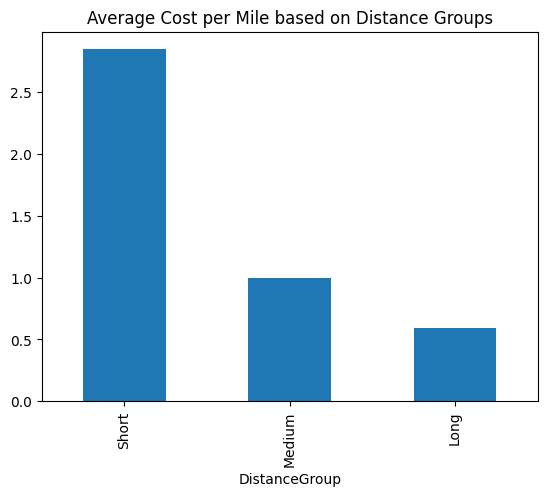

In [50]:
df.groupby('DistanceGroup')['Cost_per_Mile'].mean().plot.bar()
plt.title('Average Cost per Mile based on Distance Groups')
plt.show()

In [51]:
df['DistanceGroup'].value_counts()

DistanceGroup
Medium    30153
Long       8786
Short      1061
Name: count, dtype: int64

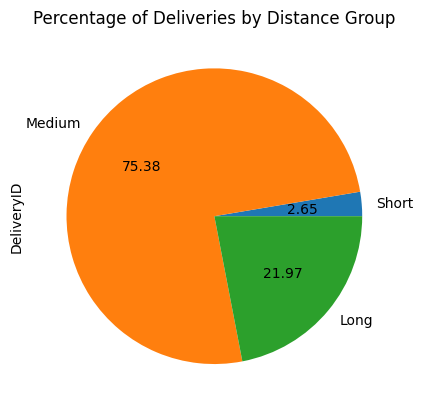

In [52]:
df.groupby('DistanceGroup')['DeliveryID'].count().plot.pie(autopct='%.2f')
plt.title('Percentage of Deliveries by Distance Group')
plt.show()

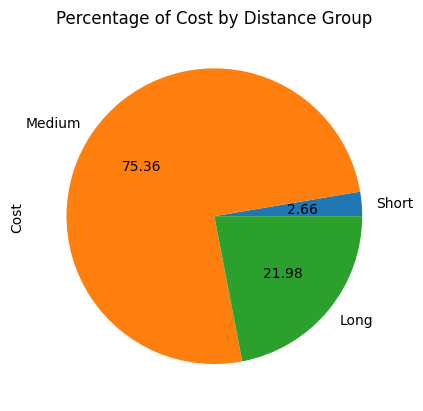

In [53]:
df.groupby('DistanceGroup')['Cost'].sum().plot.pie(autopct='%.2f')
plt.title('Percentage of Cost by Distance Group')
plt.show()

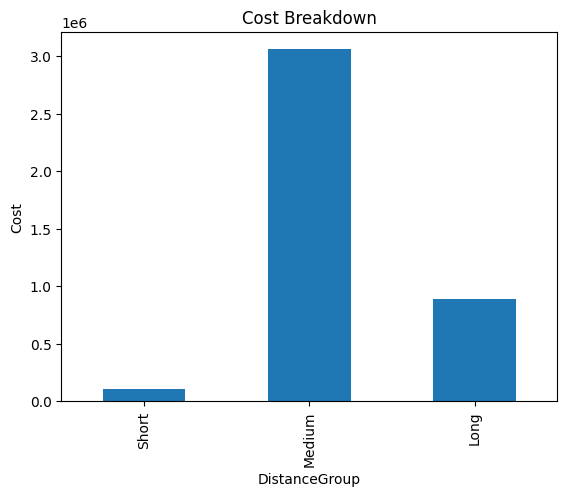

In [54]:
# Bar Plot
df.groupby('DistanceGroup')['Cost'].sum().plot.bar()
plt.title('Cost Breakdown')
plt.ylabel('Cost')
plt.show()

In [55]:
df.groupby('Month')['DeliveryID'].count().sort_values(ascending=False)

Month
May25         6872
January25     6746
March25       6686
April25       6634
February25    6081
June25        5012
December24    1969
Name: DeliveryID, dtype: int64

In [56]:
trend = df.groupby('Month')['DeliveryID'].count()

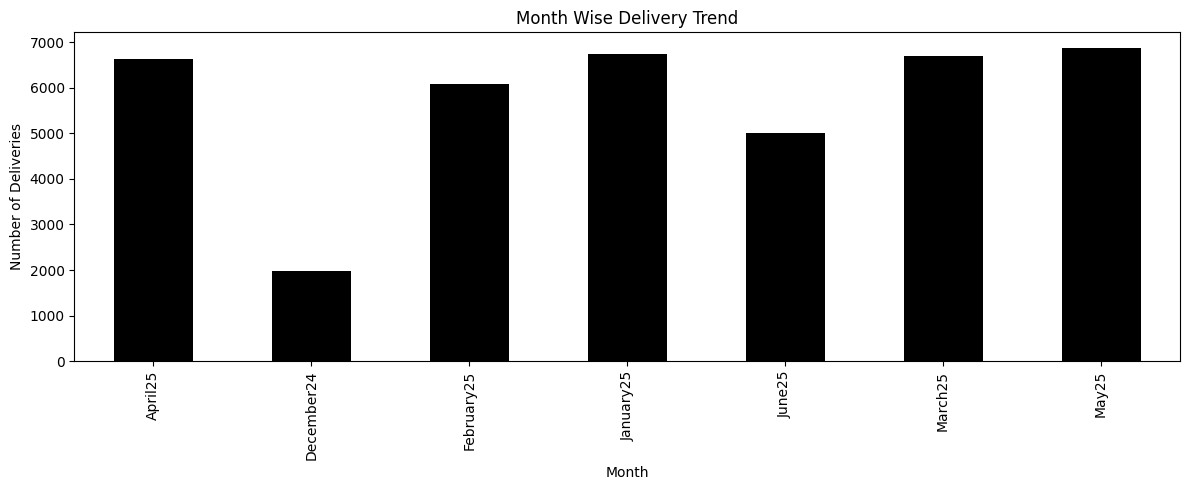

In [57]:
trend.plot(figsize=(12, 5),kind='bar', color='black')
plt.title('Month Wise Delivery Trend')
plt.ylabel('Number of Deliveries')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

<Axes: ylabel='DeliveryID'>

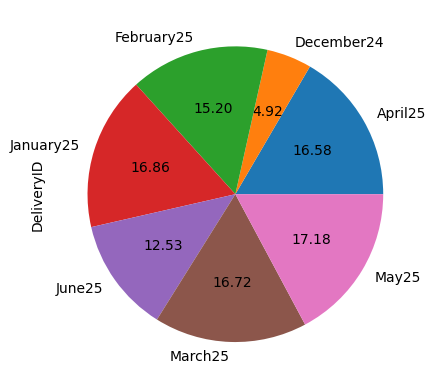

In [58]:
trend.plot.pie(autopct='%.2f')

## Bottleneck 3

### Warehouses with High Cost Per Mile

In [59]:
top_warehouses = (
    df.groupby('WarehouseID')
    .agg(AvgCostperMile=('Cost_per_Mile', 'mean'))
    .sort_values(by='AvgCostperMile', ascending=False)
    .head(10)
    .index.tolist()
)

top10_df = df[df['WarehouseID'].isin(top_warehouses)]

top10_total_cost = top10_df['Cost'].sum()

print("Top 10 Warehouses with Highest Cost per Mile:\n", top_warehouses)
print(f"Total Cost from these 10 Warehouses: ${top10_total_cost:,.2f}")

Top 10 Warehouses with Highest Cost per Mile:
 [2, 23, 41, 50, 11, 40, 12, 8, 19, 29]
Total Cost from these 10 Warehouses: $628,173.82


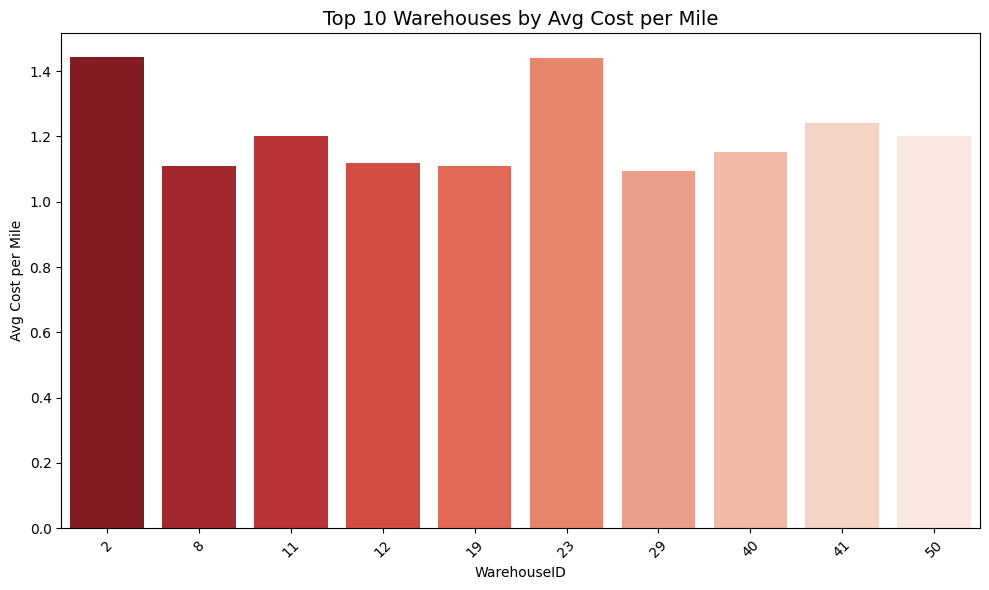

In [60]:
top_warehouses = (
    df.groupby('WarehouseID')
    .agg(AvgCostperMile=('Cost_per_Mile', 'mean'))
    .sort_values(by='AvgCostperMile', ascending=False)
    .head(10)
    .reset_index()
)

# Bar Plot

plt.figure(figsize=(10, 6))
sns.barplot(data=top_warehouses, x = 'WarehouseID', y='AvgCostperMile', palette='Reds_r')
plt.title('Top 10 Warehouses by Avg Cost per Mile', fontsize=14)
plt.ylabel('Avg Cost per Mile')
plt.xlabel('WarehouseID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
def analyze_warehouse_costs(df):

    warehouse_summary = df.groupby(['WarehouseID']).agg(
        TotalDeliveries = ('RouteID', 'count'),
        TotalCost =('Cost', 'sum'),
        TotalDistance =('Distance', 'sum'),
        AvgCostperMile = ('Cost_per_Mile', 'mean'),
        AvgDeliveryTime = ('DeliveryTime', 'mean'),
        DeliveryTime = ('DeliveryTime', 'sum')
    ).reset_index()

   # warehouse_summary['Cost_per_Mile'] = warehouse_summary['Cost'] / warehouse_summary['Distance']
    warehouse_summary = warehouse_summary.sort_values(by='AvgCostperMile', ascending=False)
    return warehouse_summary

In [62]:
warehouse_summary_real = analyze_warehouse_costs(df)
warehouse_summary_real.head(10)

,WarehouseID,TotalDeliveries,TotalCost,TotalDistance,AvgCostperMile,AvgDeliveryTime,DeliveryTime
1,2,255,25500.331250,18327.96,1.443751,6.054421,1543.877300
22,23,562,56932.581250,48691.83,1.440574,5.900836,3316.270000
40,41,889,90642.546250,91346.73,1.242737,5.937638,5278.560000
49,50,629,64103.390000,58893.79,1.202646,6.091971,3831.850000
10,11,1250,127996.481198,151956.93,1.201371,6.000900,7501.124601
39,40,396,39883.530000,37169.07,1.151243,6.072316,2404.637300
11,12,381,38510.036250,42821.06,1.120089,6.011856,2290.517300
7,8,726,72948.982500,72846.22,1.110549,5.897287,4281.430000
18,19,569,57360.818750,70525.51,1.108876,6.020088,3425.430000
28,29,536,54295.123750,61881.66,1.095069,6.180312,3312.647300


### Route Performance Heatmap

In [63]:
df['DeliveryTime'].mean()

np.float64(6.006803220365734)

In [64]:
df['DeliveryTime'].describe()

count    40000.000000
mean         6.006803
std          1.977310
min          0.600000
25%          4.650000
50%          6.007300
75%          7.350000
max         11.400000
Name: DeliveryTime, dtype: float64

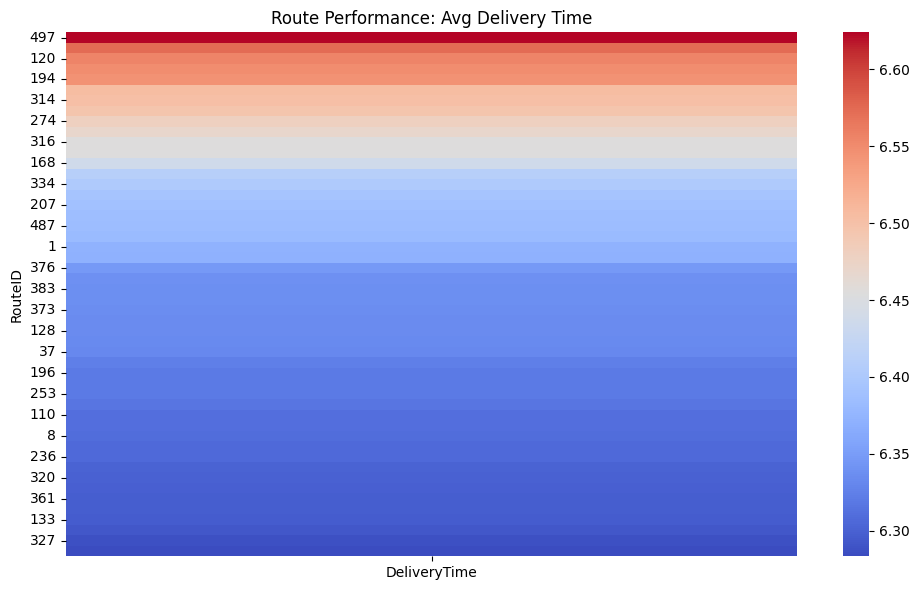

In [65]:
route_dt = df.groupby('RouteID')['DeliveryTime'].mean().reset_index()

route_dt_pivot = route_dt.pivot_table(values='DeliveryTime', index='RouteID')
# Bar Plot

plt.figure(figsize=(10, 6))
sns.heatmap(route_dt_pivot.sort_values(by='DeliveryTime', ascending=False).head(50), cmap='coolwarm', annot=False)
plt.title('Route Performance: Avg Delivery Time')
plt.ylabel('RouteID')
# plt.xlabel('Delivery Time')
plt.tight_layout()
plt.show()